## Package Import

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import Ridge
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.regularizers import l2, l1
from tensorflow.keras.models import load_model
from joblib import dump, load
import matplotlib.pyplot as plt

## Read File

In [2]:
data = pd.read_csv('OnlineNewsPopularity.csv')
data.columns = [col.strip() for col in data.columns]

## Create isolation forest model to remove outliers
[API Link to IF](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest)

In [3]:
old_data_length = len(data)
IF_model = IsolationForest(contamination=0.1) # Remove 10% data
outliers = IF_model.fit_predict(data.drop(columns=['url', 'timedelta', 'shares'])) # Delete columns than don't need in IF and train IF model
data['outliers'] = outliers

# Remove outliers
data_outliers = data[data['outliers'] == -1]
new_data = data[data['outliers'] != -1].drop(columns = ['outliers'])

new_data_len = len(new_data)

print(f"There are total {old_data_length - new_data_len} rows been removied.")

/Users/will./anaconda3/lib/python3.11/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


There are total 3965 rows been removied.


## Creat a function to classify an article to different categories
* Great Article: Shares >= 90%
* Good Article: 70% <= Shares < 90%
* Normal Article: 30% <= Shares < 70%
* Bad article: Shares < 30%

In [4]:
def article_classifier(shares, top_percent):
    if shares >= top_percent[0.9]:
        return 'Great'
    elif shares >= top_percent[0.7]:
        return 'Good'
    elif shares >= top_percent[0.3]:
        return 'Normal'
    else:
        return 'Bad'


## Data Classifier

In [5]:
top_percent = new_data['shares'].quantile([0.3, 0.7, 0.9])

quality = []
for index, row in new_data.iterrows():
    quality.append(article_classifier(row['shares'], top_percent))

new_data['quality'] = quality

## Split dataset into x and y and one-hot encode quality column

In [6]:
x = new_data.drop(columns=['quality', 'url', 'timedelta', 'shares'], axis=1)
y = new_data['quality']
le = LabelEncoder()
y = le.fit_transform(y)
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(x)
xTrain, xTest, yTrain, yTest = train_test_split(scaled_X, y, test_size=0.2, random_state=10)
scale_xTrain = pd.DataFrame(xTrain)
scale_xTest = pd.DataFrame(xTest)

## NN1

In [7]:
from keras.callbacks import EarlyStopping

nn1 = Sequential([
    Dense(256, activation='relu', input_dim=scale_xTrain.shape[1]),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(64, activation='relu', kernel_regularizer=l1(0.001)),
    Dense(4, activation='softmax'),
])

nn1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = nn1.fit(scale_xTrain, yTrain, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping])
nn1.save('nn1.h5')

Epoch 1/100
803/803 [==============================] - 1s 780us/step - loss: 1.3698 - accuracy: 0.4208 - val_loss: 1.2548 - val_accuracy: 0.4186
Epoch 2/100
803/803 [==============================] - 1s 697us/step - loss: 1.2406 - accuracy: 0.4247 - val_loss: 1.2325 - val_accuracy: 0.4266
Epoch 3/100
803/803 [==============================] - 1s 739us/step - loss: 1.2248 - accuracy: 0.4315 - val_loss: 1.2274 - val_accuracy: 0.4102
Epoch 4/100
803/803 [==============================] - 1s 702us/step - loss: 1.2172 - accuracy: 0.4340 - val_loss: 1.2165 - val_accuracy: 0.4329
Epoch 5/100
803/803 [==============================] - 1s 672us/step - loss: 1.2122 - accuracy: 0.4369 - val_loss: 1.2100 - val_accuracy: 0.4308
Epoch 6/100
803/803 [==============================] - 1s 641us/step - loss: 1.2067 - accuracy: 0.4390 - val_loss: 1.2130 - val_accuracy: 0.4326
Epoch 7/100
803/803 [==============================] - 1s 639us/step - loss: 1.2047 - accuracy: 0.4379 - val_loss: 1.2068 - val_ac

/Users/will./anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## NN1 analysis

892/892 [==============================] - 0s 330us/step
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.57      0.54      8373
           1       0.48      0.18      0.26      6171
           2       0.31      0.09      0.15      2870
           3       0.44      0.64      0.53     11129

    accuracy                           0.47     28543
   macro avg       0.44      0.37      0.37     28543
weighted avg       0.46      0.47      0.43     28543



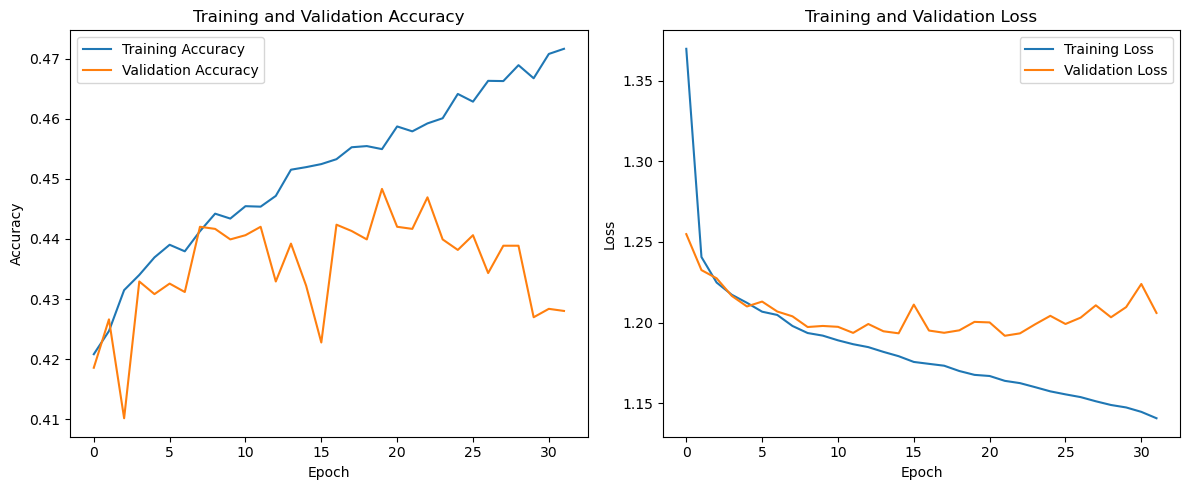

In [8]:
y_pred = nn1.predict(scale_xTrain)
y_pred_classes = np.argmax(y_pred, axis=1)
print("Classification Report:")
print(classification_report(yTrain, y_pred_classes))


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## NN2

In [11]:
nn2 = Sequential([
    Dense(512, activation='tanh', input_dim=scale_xTrain.shape[1], kernel_regularizer = tf.keras.regularizers.L1L2(0.003)),
    Dense(256, activation='tanh'),
    Dense(128, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(4, activation='softmax'),
])
nn2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = nn2.fit(scale_xTrain, yTrain, epochs=100, batch_size=32, validation_split=0.1)
nn2.save('nn2.h5')

Epoch 1/100
803/803 [==============================] - 1s 1ms/step - loss: 1.6414 - accuracy: 0.4112 - val_loss: 1.2610 - val_accuracy: 0.4186
Epoch 2/100
803/803 [==============================] - 1s 1ms/step - loss: 1.2663 - accuracy: 0.4224 - val_loss: 1.2656 - val_accuracy: 0.4161
Epoch 3/100
803/803 [==============================] - 1s 1ms/step - loss: 1.2630 - accuracy: 0.4218 - val_loss: 1.2844 - val_accuracy: 0.4154
Epoch 4/100
803/803 [==============================] - 1s 1ms/step - loss: 1.2635 - accuracy: 0.4236 - val_loss: 1.2485 - val_accuracy: 0.4196
Epoch 5/100
803/803 [==============================] - 1s 1ms/step - loss: 1.2515 - accuracy: 0.4267 - val_loss: 1.2423 - val_accuracy: 0.4126
Epoch 6/100
803/803 [==============================] - 1s 1ms/step - loss: 1.2605 - accuracy: 0.4269 - val_loss: 1.2613 - val_accuracy: 0.4168
Epoch 7/100
803/803 [==============================] - 1s 1ms/step - loss: 1.2507 - accuracy: 0.4317 - val_loss: 1.2531 - val_accuracy: 0.4168

/Users/will./anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## NN2 Analysis

892/892 [==============================] - 0s 403us/step
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.53      0.50      8373
           1       0.46      0.09      0.16      6171
           2       0.50      0.00      0.00      2870
           3       0.42      0.67      0.51     11129

    accuracy                           0.44     28543
   macro avg       0.46      0.32      0.29     28543
weighted avg       0.45      0.44      0.38     28543



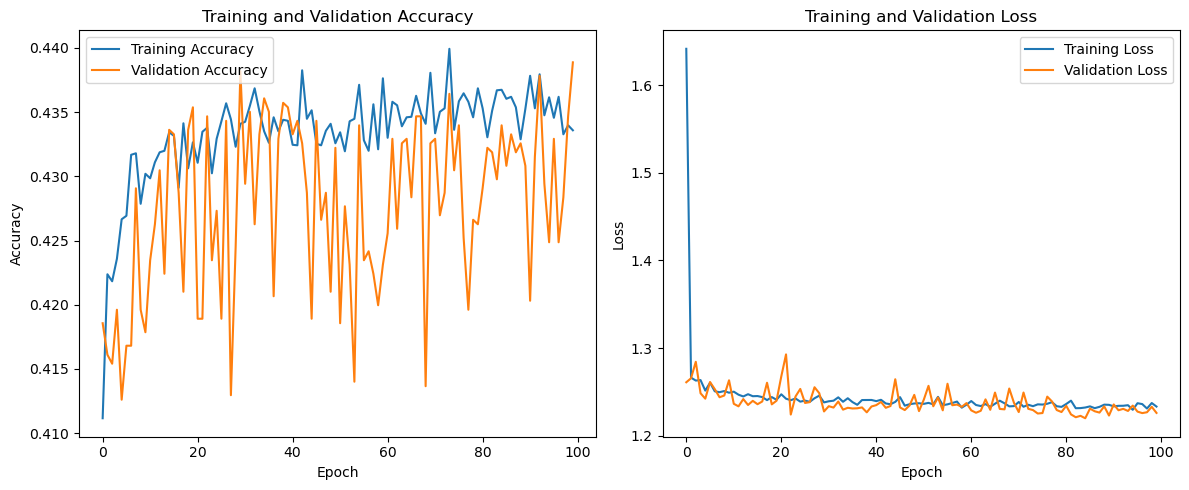

In [12]:
y_pred = nn2.predict(scale_xTrain)
y_pred_classes = np.argmax(y_pred, axis=1)
print("Classification Report:")
print(classification_report(yTrain, y_pred_classes))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Random Forest

In [ ]:
RF_model = RandomForestClassifier(n_estimators=200)
RF_model.fit(scale_xTrain, yTrain)
dump(RF_model, 'RF.joblib')

['RF.joblib']

## RF Analysis

In [ ]:
y_pred = RF_model.predict(scale_xTest)
print("Classification Report:")
print(classification_report(yTrain, y_pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.87      0.84      8339
           1       0.80      0.78      0.79      5656
           2       0.85      0.75      0.79      2904
           3       0.84      0.84      0.84     11644

    accuracy                           0.83     28543
   macro avg       0.83      0.81      0.82     28543
weighted avg       0.83      0.83      0.83     28543
